In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

[*********************100%%**********************]  1 of 1 completed


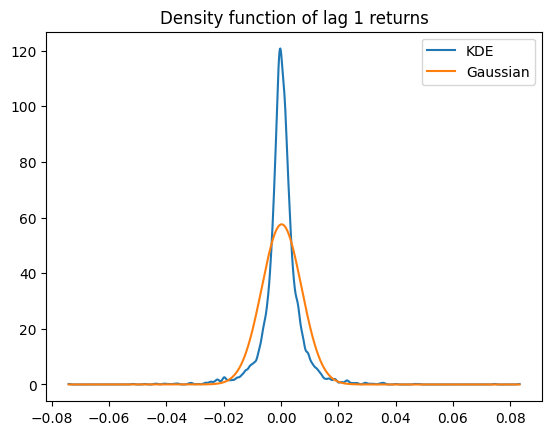

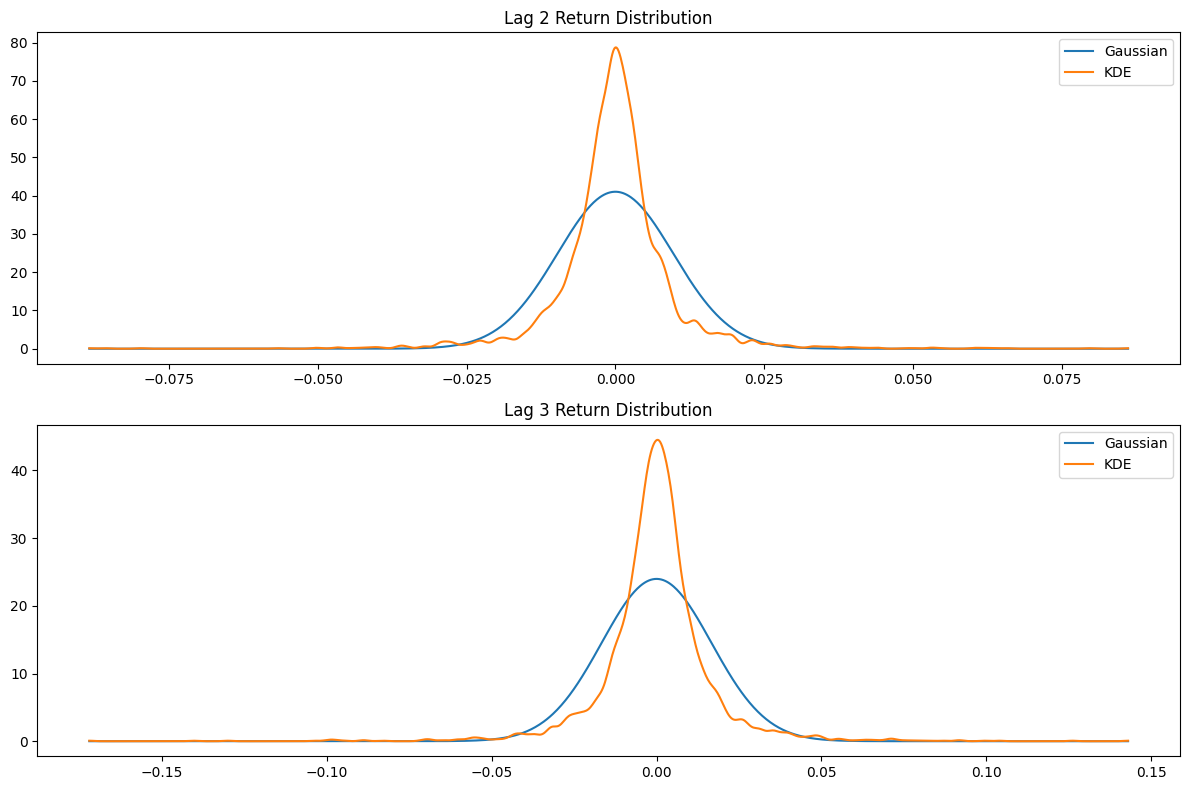

In [3]:
# dowload all the google data available from yahoo finance:
import yfinance as yf
from scipy.stats import norm, gaussian_kde


# download all the available data
data = yf.download('GOOGL', end='2020-01-01')

# get the closing prices
close = data['Close']

# we normalize the data with a scaler
from sklearn.preprocessing import MinMaxScaler
total_scaler = MinMaxScaler()
close = total_scaler.fit_transform(close.values.reshape(-1, 1))

# we slice the data with a slicing window of 60 dayes
sliced_data = []
for i in range(60, len(close)):
    sliced_data.append(close[i-60:i])

# we convert the data into a tensor
sliced_data = np.array(sliced_data)
sliced_data= sliced_data.reshape(sliced_data.shape[0], sliced_data.shape[1])

# we save the data in data/sliced_data.csv
pd.DataFrame(sliced_data).to_csv('data/sliced_data.csv', index=False)

# Calculate the lag 1 return for each slicing window
lag_1_returns_original = [np.diff(time_series) for time_series in sliced_data]

# Flatten the returns to 1D
lag_1_returns_original = np.concatenate(lag_1_returns_original)

# Calculate the mean and standard deviation of the returns
mean_original = np.mean(lag_1_returns_original)
std_original = np.std(lag_1_returns_original)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian_original = norm(loc=mean_original, scale=std_original)

# Generate values for the x axis
x_original = np.linspace(min(lag_1_returns_original), max(lag_1_returns_original), 1000)

# Estimate the density function of the lag 1 return using KDE
kde_original = gaussian_kde(lag_1_returns_original)
lag_1_return_density_original = kde_original(x_original)

# plot the density function
plt.plot(x_original, lag_1_return_density_original, label='KDE')
plt.plot(x_original, gaussian_original.pdf(x_original), label='Gaussian')
plt.legend()
plt.title('Density function of lag 1 returns')
plt.show()

# Calculate the lag 2 and lag 3 returns for each slicing window
lag_2_returns_original = [np.diff(time_series, n=2) for time_series in sliced_data]
lag_3_returns_original = [np.diff(time_series, n=3) for time_series in sliced_data]

# Flatten the returns to 1D
lag_2_returns_original = np.concatenate(lag_2_returns_original)
lag_3_returns_original = np.concatenate(lag_3_returns_original)

# Calculate the mean and standard deviation of the returns
mean_original_2 = np.mean(lag_2_returns_original)
std_original_2 = np.std(lag_2_returns_original)

mean_original_3 = np.mean(lag_3_returns_original)
std_original_3 = np.std(lag_3_returns_original)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian_original_2 = norm(loc=mean_original_2, scale=std_original_2)
gaussian_original_3 = norm(loc=mean_original_3, scale=std_original_3)

# Generate values for the x axis
x_original_2 = np.linspace(min(lag_2_returns_original), max(lag_2_returns_original), 1000)
x_original_3 = np.linspace(min(lag_3_returns_original), max(lag_3_returns_original), 1000)

# Estimate the density function of the lag 2 and lag 3 returns using KDE
kde_original_2 = gaussian_kde(lag_2_returns_original)
kde_original_3 = gaussian_kde(lag_3_returns_original)

lag_2_return_density_original = kde_original_2(x_original_2)
lag_3_return_density_original = kde_original_3(x_original_3)

# Plot the distributions
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(x_original_2, gaussian_original_2.pdf(x_original_2), label='Gaussian')
plt.plot(x_original_2, lag_2_return_density_original, label='KDE')
plt.title('Lag 2 Return Distribution')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x_original_3, gaussian_original_3.pdf(x_original_3), label='Gaussian')
plt.plot(x_original_3, lag_3_return_density_original, label='KDE')
plt.title('Lag 3 Return Distribution')
plt.legend()

plt.tight_layout()
plt.show()



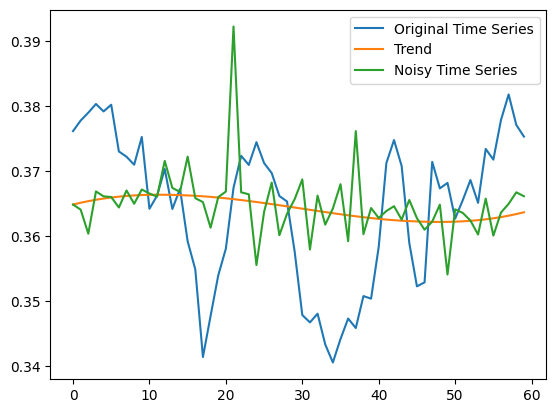

100%|██████████| 1000/1000 [01:54<00:00,  8.74it/s]


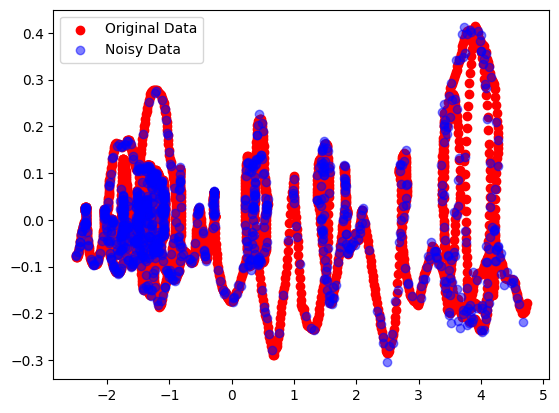

In [39]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the time series data to 2
pca = PCA(n_components=2)
sliced_data_pca = pca.fit_transform(sliced_data)

# save into a csv file
pd.DataFrame(sliced_data_pca).to_csv('data/sliced_data_pca.csv', index=False)

# Create a mapping from PCA points to both the inverse PCA and the real time series
pca_to_time_series = {tuple(pca_point): (pca.inverse_transform(pca_point), real_point) 
                      for pca_point, real_point in zip(sliced_data_pca, sliced_data)}



def add_noise(trend, noise_factor=1):
    # Initialize the new time series with the first three values of the trend
    new_time_series = [trend[0]]

    for i in range(1, len(trend),3):
        # Sample a return from the lag 1, lag 2 and lag 3 return distributions
        sampled_return_1 = kde_original.resample(1)[0][0] * noise_factor
        sampled_return_2 = kde_original_2.resample(1)[0][0] * noise_factor
        sampled_return_3 = kde_original_3.resample(1)[0][0] * noise_factor

        # Calculate the next three values of the new time series
        next_value_1 = trend[i] * (1 + sampled_return_1)
        next_value_2 = trend[i] * (1 + sampled_return_2) if i+1 < len(trend) else None
        next_value_3 = trend[i] * (1 + sampled_return_3) if i+2 < len(trend) else None

        # Append the next values to the new time series
        new_time_series.append(next_value_1)

        if next_value_2 is not None:
            new_time_series.append(next_value_2)
        if next_value_3 is not None:
            new_time_series.append(next_value_3)

    new_time_series = np.array(new_time_series)
    return new_time_series

# select a random pca point
index = np.random.choice(sliced_data_pca.shape[0], 1, replace=False)

# get the corresponding time series and trend
pca_point = sliced_data_pca[index][0]
trend, time_series = pca_to_time_series[tuple(pca_point)]

# add noise to the time series
noisy_series = add_noise(trend)

# plot the original time series and the noisy time series
plt.plot(time_series, label='Original Time Series')
plt.plot(trend, label='Trend')
plt.plot(noisy_series, label='Noisy Time Series')
plt.legend()
plt.show()


# Select 1000 random PCA points
indices = np.random.choice(sliced_data_pca.shape[0], 1000, replace=False)
selected_pca_points = sliced_data_pca[indices]

# Create noisy time series for the selected PCA points
noisy_time_series = []
for pca_point in tqdm(selected_pca_points):
    # Get the corresponding time series
    _, time_series = pca_to_time_series[tuple(pca_point)]
    
    # Add noise to the time series
    noisy_series = add_noise(time_series)
    
    # Store the noisy time series
    noisy_time_series.append(noisy_series)

# Apply PCA to the noisy time series
noisy_data_pca = pca.transform(noisy_time_series)

# Plot the PCA of the noisy time series on the PCA of the original data
plt.scatter(sliced_data_pca[:, 0], sliced_data_pca[:, 1], label='Original Data', c = 'red')
plt.scatter(noisy_data_pca[:, 0], noisy_data_pca[:, 1], label='Noisy Data', c = 'blue', alpha=0.5)
plt.legend()
plt.show()


In [5]:
# import the gerated samples
generated_pca = pd.read_csv('data/GAN3_generated_pca.csv').values

# generate TS from the pcs points
noisy_generated_time_series = []
for pca_point in tqdm(generated_pca):
    # Get the trend corresponding to the pca point via inverse transofrmation
    trend = pca.inverse_transform(pca_point)
    
    # Add noise to the time series
    noisy_series = add_noise(trend)
    
    # Store the noisy time series
    noisy_generated_time_series.append(noisy_series)

# save into a csv file
pd.DataFrame(noisy_generated_time_series).to_csv('data/GAN3_generated_slices.csv', index=False)


100%|██████████| 1995/1995 [03:26<00:00,  9.65it/s]


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

def train_test_divide(dataX, dataX_hat):
    trainX, testX = train_test_split(dataX, test_size=0.2, random_state=42)
    trainX_hat, testX_hat = train_test_split(dataX_hat, test_size=0.2, random_state=42)
    return trainX, trainX_hat, testX, testX_hat

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        out = self.fc2(h)
        return out, self.sigmoid(out)

def discriminative_score_metrics(dataX, dataX_hat):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0])

    # Network Parameters
    hidden_dim = max(int(data_dim/2),1)
    iterations = 2000
    batch_size = 128

    model = Discriminator(data_dim, hidden_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters())

    # Train / Test Division
    trainX, trainX_hat, testX, testX_hat = train_test_divide(dataX, dataX_hat)

    # Training step
    for itt in range(iterations):
        model.train()
        optimizer.zero_grad()

        # Batch setting
        idx = np.random.permutation(len(trainX))[:batch_size]
        X_mb = torch.stack([trainX[i] for i in idx]).to(device)

        # Batch setting
        idx = np.random.permutation(len(trainX_hat))[:batch_size]
        X_hat_mb = torch.stack([trainX_hat[i] for i in idx]).to(device)

        # Train discriminator
        Y_real, Y_pred_real = model(X_mb)
        Y_fake, Y_pred_fake = model(X_hat_mb)

        D_loss_real = criterion(Y_real, torch.ones_like(Y_real))
        D_loss_fake = criterion(Y_fake, torch.zeros_like(Y_fake))
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        optimizer.step()

    # Final Outputs (on Testing set)
    model.eval()
    with torch.no_grad():
        Y_real, Y_pred_real = model(torch.tensor(testX).to(device))
        Y_fake, Y_pred_fake = model(torch.tensor(testX_hat).to(device))

    Y_pred_final = torch.cat((Y_pred_real, Y_pred_fake), dim=0).cpu().numpy()
    Y_label_final = np.concatenate((np.ones([len(Y_pred_real),]), np.zeros([len(Y_pred_real),])), axis = 0)

    # Accuracy
    Acc = accuracy_score(Y_label_final, Y_pred_final>0.5)

    Disc_Score = np.abs(0.5-Acc)

    return Disc_Score

In [41]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# import the normalized slices
slices = sliced_data 

# takes 1000 random slices
slices = np.array(slices)
slices = slices[np.random.choice(slices.shape[0], 1000, replace=False)]
real_samples = slices


generated_samples = noisy_time_series

# convert the data to numpy arrays
real_samples = np.array(real_samples)
generated_samples = np.array(generated_samples)

# Convert real_samples and generated_samples to PyTorch tensors
real_samples = torch.from_numpy(real_samples).float()
generated_samples = torch.from_numpy(generated_samples).float()

print(real_samples.shape)
print(generated_samples.shape)

scores = []
for i in tqdm(range(30)):

    # Now you can call the function
    disc_score = discriminative_score_metrics(real_samples, generated_samples)
    scores.append(disc_score)

mean = np.mean(scores)
std = np.std(scores)

print('Mean Discriminative Score: %.4f' % mean)
print('Standard Deviation of Discriminative Score: %.4f' % std)

torch.Size([1000, 60])
torch.Size([1000, 60])


100%|██████████| 30/30 [00:30<00:00,  1.00s/it]

Mean Discriminative Score: 0.0113
Standard Deviation of Discriminative Score: 0.0088


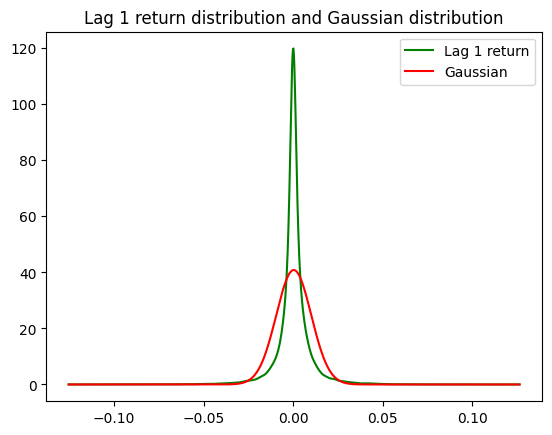

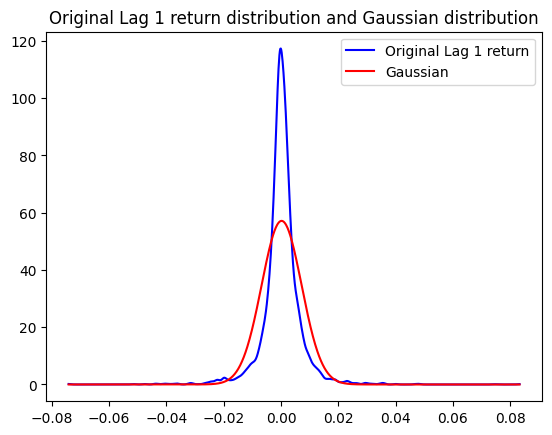

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde


# Calculate the lag 1 return for each time series
lag_1_returns = [np.diff(time_series) for time_series in generated_samples]

# Flatten the returns to 1D
lag_1_returns = np.concatenate(lag_1_returns)

# Calculate the mean and standard deviation of the returns
mean = np.mean(lag_1_returns)
std = np.std(lag_1_returns)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian = norm(loc=mean, scale=std)

# Generate values for the x axis
x = np.linspace(min(lag_1_returns), max(lag_1_returns), 1000)

# Estimate the density function of the lag 1 return using KDE
kde = gaussian_kde(lag_1_returns)
lag_1_return_density = kde(x)

# Plot the density function of the lag 1 return
plt.plot(x, lag_1_return_density, color='g', label='Lag 1 return')

# Plot the Gaussian distribution
plt.plot(x, gaussian.pdf(x), 'r', label='Gaussian')

plt.title('Lag 1 return distribution and Gaussian distribution')
plt.legend()
plt.show()

original_samples = real_samples

# Calculate the lag 1 return for each slicing window
lag_1_returns_original = [np.diff(time_series) for time_series in original_samples]

# Flatten the returns to 1D
lag_1_returns_original = np.concatenate(lag_1_returns_original)

# Calculate the mean and standard deviation of the returns
mean_original = np.mean(lag_1_returns_original)
std_original = np.std(lag_1_returns_original)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian_original = norm(loc=mean_original, scale=std_original)

# Generate values for the x axis
x_original = np.linspace(min(lag_1_returns_original), max(lag_1_returns_original), 1000)

# Estimate the density function of the lag 1 return using KDE
kde_original = gaussian_kde(lag_1_returns_original)
lag_1_return_density_original = kde_original(x_original)

# Plot the density function of the lag 1 return
plt.plot(x_original, lag_1_return_density_original, color='b', label='Original Lag 1 return')

# Plot the Gaussian distribution
plt.plot(x_original, gaussian_original.pdf(x_original), 'r', label='Gaussian')

plt.title('Original Lag 1 return distribution and Gaussian distribution')
plt.legend()
plt.show()

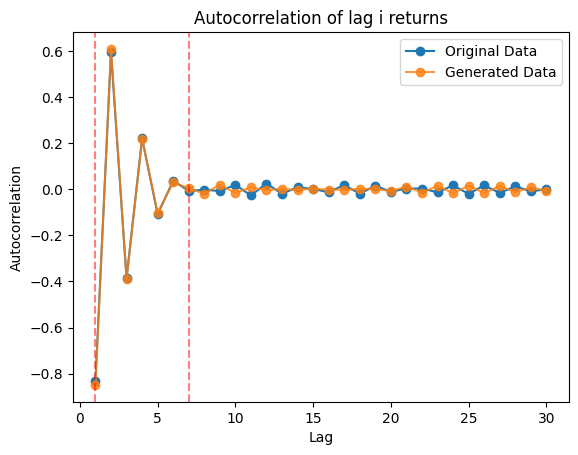

In [44]:
from statsmodels.tsa.stattools import acf


# Calculate the lag i return for each slicing window
lag_returns_original = [np.diff(time_series, n=i) for i in range(1, 31) for time_series in original_samples]

# Exclude short time series
lag_returns_original = [lag_return for lag_return in lag_returns_original if len(lag_return) >= 31]

# Calculate the autocorrelation for each lag
autocorrelations = [acf(lag_return, nlags=30, fft=True) for lag_return in lag_returns_original]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_original = np.mean(autocorrelations, axis=0)[1:]

# Calculate the lag i return for each generated time series
lag_returns_generated = [np.diff(time_series, n=i) for i in range(1, 31) for time_series in generated_samples]

# Exclude short time series
lag_returns_generated = [lag_return for lag_return in lag_returns_generated if len(lag_return) >= 31]

# Calculate the autocorrelation for each lag
autocorrelations_generated = [acf(lag_return, nlags=30, fft=True) for lag_return in lag_returns_generated]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_generated = np.mean(autocorrelations_generated, axis=0)[1:]

# Plot the autocorrelation for each lag
plt.plot(range(1, 31), mean_autocorrelations_original, marker='o', label='Original Data')
plt.plot(range(1, 31), mean_autocorrelations_generated, marker='o', label='Generated Data', alpha=0.8)

# Add vertical lines at lag = 1 and lag = 7
plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=7, color='r', linestyle='--', alpha=0.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of lag i returns')
plt.legend()
plt.show()

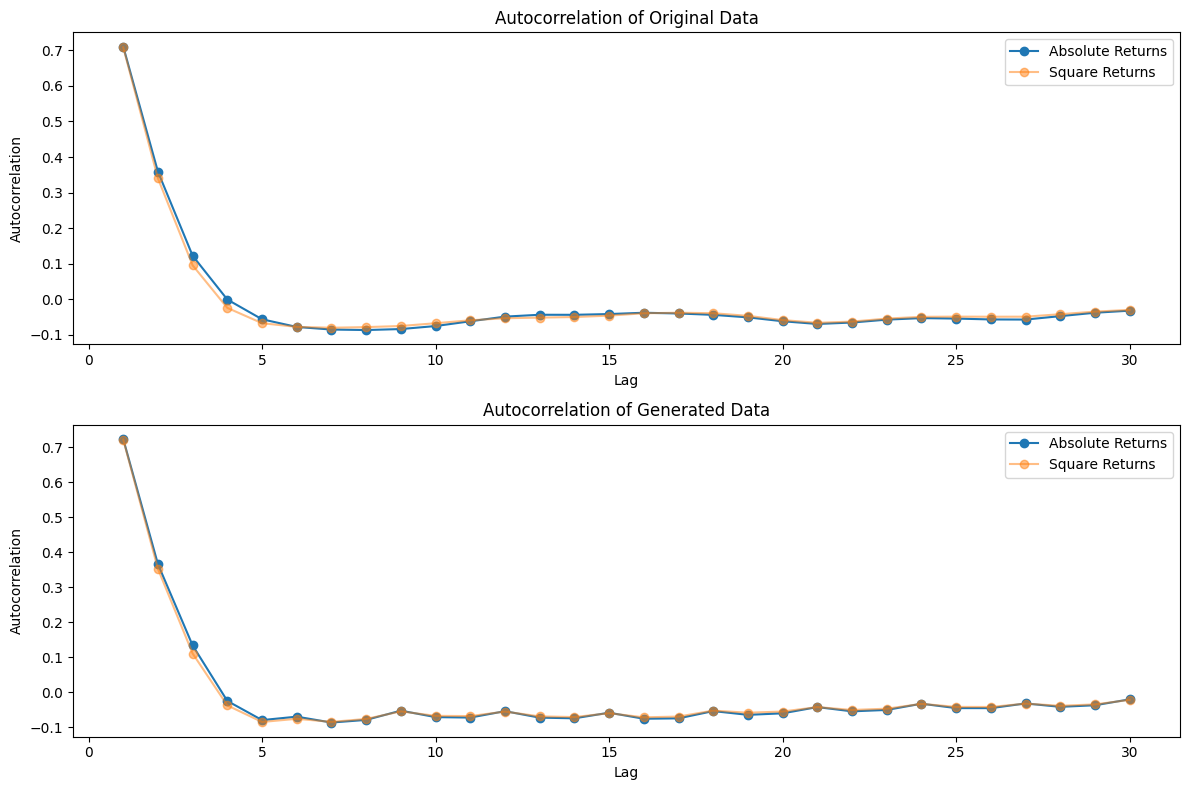

In [45]:
# Calculate the absolute and square returns
abs_returns_original = [np.abs(np.diff(time_series, n=i)) for i in range(1, 31) for time_series in original_samples]
sq_returns_original = [np.diff(time_series, n=i)**2 for i in range(1, 31) for time_series in original_samples]

abs_returns_generated = [np.abs(np.diff(time_series, n=i)) for i in range(1, 31) for time_series in generated_samples]
sq_returns_generated = [np.diff(time_series, n=i)**2 for i in range(1, 31) for time_series in generated_samples]

# Exclude short time series
abs_returns_original = [abs_return for abs_return in abs_returns_original if len(abs_return) >= 31]
sq_returns_original = [sq_return for sq_return in sq_returns_original if len(sq_return) >= 31]

abs_returns_generated = [abs_return for abs_return in abs_returns_generated if len(abs_return) >= 31]
sq_returns_generated = [sq_return for sq_return in sq_returns_generated if len(sq_return) >= 31]


# Calculate the autocorrelation for each lag
autocorrelations_abs_original = [acf(abs_return, nlags=30, fft=True) for abs_return in abs_returns_original]
autocorrelations_sq_original = [acf(sq_return, nlags=30, fft=True) for sq_return in sq_returns_original]

autocorrelations_abs_generated = [acf(abs_return, nlags=30, fft=True) for abs_return in abs_returns_generated]
autocorrelations_sq_generated = [acf(sq_return, nlags=30, fft=True) for sq_return in sq_returns_generated]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_abs_original = np.mean(autocorrelations_abs_original, axis=0)[1:]
mean_autocorrelations_sq_original = np.mean(autocorrelations_sq_original, axis=0)[1:]

mean_autocorrelations_abs_generated = np.mean(autocorrelations_abs_generated, axis=0)[1:]
mean_autocorrelations_sq_generated = np.mean(autocorrelations_sq_generated, axis=0)[1:]

# Plot the autocorrelation for each lag
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range(1, 31), mean_autocorrelations_abs_original, marker='o', label='Absolute Returns')
plt.plot(range(1, 31), mean_autocorrelations_sq_original, marker='o', label='Square Returns', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Original Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, 31), mean_autocorrelations_abs_generated, marker='o', label='Absolute Returns')
plt.plot(range(1, 31), mean_autocorrelations_sq_generated, marker='o', label='Square Returns', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Generated Data')
plt.legend()

plt.tight_layout()
plt.show()

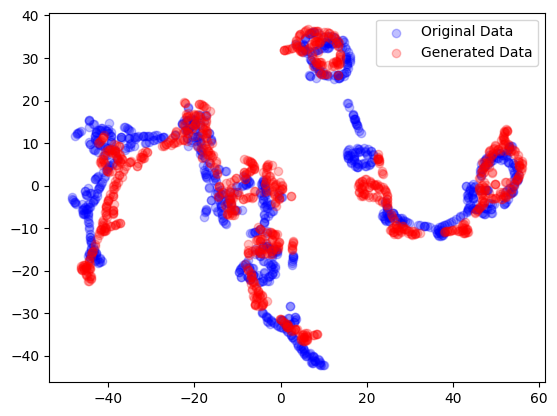

In [46]:
# lets plot the tsne of the original and generated data
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the original data
original_tsne = tsne.fit_transform(original_samples)

# Fit and transform the generated data
generated_tsne = tsne.fit_transform(generated_samples)

# Plot the original and generated data on the t-SNE space
plt.scatter(original_tsne[:, 0], original_tsne[:, 1], label='Original Data', c='blue',alpha=0.25)
plt.scatter(generated_tsne[:, 0], generated_tsne[:, 1], label='Generated Data', c='red', alpha=0.25)
plt.legend()
plt.show()


In [48]:
########################### recover the time series from the generated pca points ##########################
# You need to generate pca points with the file generattion_gan# before running this code

# import the generated pca points
generated_pca = pd.read_csv('data/GAN3_generated_pca.csv').values

# generate TS from the pcs points
generated_time_series = []
for pca_point in tqdm(generated_pca):
    # Get the trend corresponding to the pca point via inverse transformation
    trend = pca.inverse_transform(pca_point)
    
    # Add noise to the time series
    noisy_series = add_noise(trend)
    
    # Store the noisy time series
    generated_time_series.append(noisy_series)

# save into a csv file
pd.DataFrame(generated_time_series).to_csv('data/GAN3_generated_slices.csv', index=False)

100%|██████████| 1995/1995 [02:42<00:00, 12.29it/s]
